In [1]:
import random
import csv
import torch
import torch.nn as nn
import networkx as nx
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torch.distributions import Categorical
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
class network(nn.Module):
    
    def __init__(self , num_state , num_action):
        
        super().__init__()
        self.fc1 = nn.Linear(num_state , 1024 )
        self.fc2 = nn.Linear(1024 , 512)
        self.fc3 = nn.Linear(512 , 256)
        self.fc4 = nn.Linear(256 , 128)
        self.fc5 = nn.Linear(128 , 64)
        self.fc6 = nn.Linear(64 , 32)
        self.fc7 = nn.Linear(32 , 16)
        self.out = nn.Linear(16 , num_action )
    
    def forward(self , x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.out(x)
        return x

class ReplayBuffer(object):
    '''
    
    This code is copied from openAI baselines
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    '''
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes , dtype = np.float32):
        
        
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False,dtype=dtype))
            actions.append(np.array(action, copy=False,dtype=np.long))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False,dtype=dtype))
            dones.append(done)
        return np.array(obses_t,dtype=dtype), np.array(actions , dtype = np.long), \
    np.array(rewards  ,dtype=dtype), np.array(obses_tp1,dtype=dtype), np.array(dones , dtype = bool)
    
    
    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

    
class Agent():
    
    def __init__(self , num_state , num_action):
        
        
        
        self.policy_network = network(num_state , num_action)
        self.target_network = network(num_state , num_action)
        
        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        self.steps_done = 0
        self.num_state = num_state
        self.num_action = num_action
        
        self.EPS_END = 0.05
        self.EPS_START = 0.999
        
        self.EPS_DECAY = 30000
        self.batch_size = 64
        self.buffer = ReplayBuffer( 4000 )
#         self.optimizer = torch.optim.Adam(self.policy_network.parameters()   , amsgrad=True)
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(),lr=0.00002)
    def take_action(self , x , adj_array, is_testing = False ) :
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        if(self.steps_done%300) == 0:
            print(eps_threshold)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        rand_val = np.random.uniform()
        if rand_val > eps_threshold or is_testing == True:
            val = self.policy_network(x)
            mask_list = [0] * self.num_state
            for item in adj_array :
                mask_list[item] = 1
            for i in range(len(mask_list)):
                if(mask_list[i] == 0):
                    val[i] = float('-Infinity')
            action = torch.argmax(val).item()
            
            
        else:
            action = np.random.choice(adj_array)
        
        if is_testing == False:
            self.steps_done += 1
        
        return action
            
    
    def store_transition(self, state , action , reward , next_state , done ):
        
        self.buffer.add(state , action , reward , next_state , done)
    
    def update_parameters(self):
        
        if len(self.buffer) < self.batch_size:
            return 
        
        loss_fn = torch.nn.MSELoss(reduction = 'mean')
        
        batch = self.buffer.sample(self.batch_size)
        states , actions , rewards , next_states , dones = batch
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions).view(-1,1)
        rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        actions = actions.long()
        
        non_final_mask = torch.tensor(tuple(map(lambda s : s != True, dones)),dtype = torch.bool)
        non_final_next_state = next_states[non_final_mask]
        
        pred_q = self.policy_network(states).gather(1 , actions).view(-1) 
        next_state_value = torch.zeros(self.batch_size).detach()
        
        D_action = self.policy_network(non_final_next_state).argmax(1).view(-1,1)
        next_state_value[non_final_mask] = self.target_network(non_final_next_state).gather(1 , D_action).view(-1) 
        expected_q = (next_state_value + rewards).detach()
        
        loss = loss_fn(pred_q , expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def update_target_weight(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

In [3]:
def distance(nodes, node1, node2):
    x = (nodes[node1][1] - nodes[node2][1])**2
    y = (nodes[node1][2] - nodes[node2][2])**2
    return (x+y)**(1/2)

In [4]:
def clustering():
    check_list = []
    count = -1
    clustering_info = []
    for index in range(num_nodes):
        prev_check_list = []
        if index not in check_list:
            count+=1
            clustering_info.append([])
            check_list.append(index)
            prev_check_list.append(index)
            clustering_info[count].append(index)
            while(len(prev_check_list)!=0):
                next_check_list = []
                for j in range (len(prev_check_list)):
                    node1 = prev_check_list[j]
                    i = 0
                    while(i<len(nodes_dis[node1]) and nodes_dis[node1][i][1]<=t_constraint):
                        node2 = nodes_dis[node1][i][0]
                        if node2 not in check_list:
                            check_list.append(node2)
                            next_check_list.append(node2)
                            clustering_info[count].append(node2)
                        i+=1    
                prev_check_list = next_check_list
    return clustering_info

In [5]:
def communication():
    for i in range(k_agents): 
        for j in range(i+1,k_agents):
            if nodes_dis2[now_point[i]][now_point[j]] >= t_constraint:
                flag[i][j] = 0
                flag[j][i] = 0
            elif nodes_dis2[now_point[i]][now_point[j]] < t_constraint and flag[i][j] == 0:
                flag[i][j] = 1
                flag[j][i] = 1
                for k in range(num_nodes):
                    for z in range(k+1, num_nodes):
                        s = max(state_map[i][k][z],state_map[j][k][z])
                        state_map[i][k][z] = s
                        state_map[j][k][z] = s
                        state_map[i][z][k] = s
                        state_map[j][z][k] = s

In [6]:
def generator():
    data = open("data_10_var.txt",'w+') 
    num_nodes = 10
    print(num_nodes, file=data)
    num_edges = random.randint((num_nodes-1)*(num_nodes-2)/2+1,num_nodes*(num_nodes-1)/2)
    print(num_edges, file=data)
    random_list = [0] * num_nodes
    state_check = []
    for i in range(num_nodes):
        state_check.append([])
        random_list[i] = i
        pos_x = random.randint(0,1000)
        pos_y = random.randint(0,1000)
        print(i, pos_x, pos_y, file=data)
    for i in range(num_edges):
        flag_input = 0
        while flag_input == 0: 
            sample_list = random.sample(random_list,2)
            length = random.randint(0,1000)
            a = sample_list[0]
            b = sample_list[1]
            if b not in state_check[a]:
                state_check[a].append(b)
                state_check[b].append(a)
                print(a, b, length, file=data)
                flag_input = 1
            else:
                flag_input = 0
    k_agents = 3
    print(k_agents, file=data)
    for i in range(k_agents):
        now_point = random.randint(0,num_nodes-1)
        speed = random.randint(1,10)
        print(i, now_point, speed, file=data)
    constraint = 500
    print(constraint, file=data)
    data.close()

In [9]:
file = open('data.txt')
lines = file.readlines()
num_nodes = int(lines[0])
num_edges = int(lines[1])
agent = Agent(num_nodes , num_nodes)
reward_history = []
cost = 3000
for e in tqdm(range(50)):
    #generator()
#     file = open('data.txt')
#     lines = file.readlines()
#     num_nodes = int(lines[0])
#     num_edges = int(lines[1])
    print(cost)
#     if(cost <= 1843):
#         break
    nodes = []
    state = []
    edge_len = [[0]*num_nodes for i in range(num_nodes)]
    god_map = [[0]*num_nodes for i in range(num_nodes)]
    nodes_dis = []
    nodes_dis2 = [[0]*num_nodes for i in range(num_nodes)]
    on_nodes = []
    info_speed = []
    features = []
    prev_features = []
    Adj = [[0]*num_nodes for i in range(num_nodes)]
    
    for i in range(num_nodes):
        state.append([])
        nodes_dis.append([])
        on_nodes.append([])
        curLine = lines[i+2].strip().split(" ")
        intLine = list(map(int, curLine))
        nodes.append([intLine[0], intLine[1], intLine[2]])
        for j in range(i-1, -1, -1):
            dis = distance(nodes, i, j)
            nodes_dis[i].append((j, dis))
            nodes_dis[j].append((i, dis))
            nodes_dis2[i][j] = dis
            nodes_dis2[j][i] = dis
    for i in range(len(nodes_dis)):
        nodes_dis[i].sort(key=lambda nodes_dis: nodes_dis[1])

    for i in range(num_edges):
        curLine = lines[i+2+num_nodes].strip().split(" ")
        intLine = list(map(int, curLine))
        state[intLine[0]].append(intLine[1])
        state[intLine[1]].append(intLine[0])
        edge_len[intLine[0]][intLine[1]] = intLine[2]
        edge_len[intLine[1]][intLine[0]] = intLine[2]
        Adj[intLine[0]][intLine[1]] = 1
        Adj[intLine[1]][intLine[0]] = 1
    Adj = torch.FloatTensor(Adj)
    k_agents = int(lines[2+num_nodes+num_edges])
    flag = [[0]*k_agents for i in range(k_agents)]
    for k in range(k_agents):
        features.append([])
        prev_features.append([])
        for i in range(num_nodes):
            features[k].append([])
            prev_features[k].append([])
            for j in range(num_nodes):
                features[k][i].append(0)
                prev_features[k][i].append(0)
        
    now_point = [0] * k_agents
    speed = [0]*k_agents
    target = [0]*k_agents
    location = [0]*k_agents
    x_agent = []
    y_agent = []

    for i in range(k_agents):
        x_agent.append([])
        y_agent.append([])
        info_speed.append([])
        curLine = lines[i+3+num_nodes+num_edges].strip().split(" ")
        intLine = list(map(int, curLine))
        #now_point[intLine[0]] = intLine[1]
        now_point[i] = random.randint(0, num_nodes-1)
        speed[intLine[0]] = intLine[2]

    t_constraint = int(lines[3+num_nodes+num_edges+k_agents])
       
    print(now_point)
#     print(state)
#     print(speed)
#     print(edge_len)
    
    history_route = []
    state_map = []
    for i in range(k_agents):
        history_route.append([])
        history_route[i].append(now_point[i])
        on_nodes[now_point[i]].append(i)
        state_map.append([]) 
    for i in range(k_agents):
        state_map[i] = [[0] * num_nodes for i in range(num_nodes)]
    
    finish_count = 0
    cost = 0
    pre_step = [0]*k_agents
    info_clustering = clustering()
    reward_sum = 0.0
    while finish_count < num_edges:
        communication()
#         for i in range(k_agents):
#             for state_index in range(num_nodes):
#                 for state_index2 in range(num_nodes):
#                     if(state_map[i][state_index][state_index2] >= 1):
#                         features[i][state_index][state_index2] = 1
        cost+=1
        for i in range(k_agents):
            list_x = []
            list_y = []
            if target[i]==0:
                  
                for state_index in range(num_nodes):
                    for state_index2 in range(num_nodes):
                        if(state_map[i][state_index][state_index2] >= 1):
                            features[i][state_index][state_index2] = 1
                reward = 0
                pre_step[i] = now_point[i]
                action = agent.take_action(np.array(features[i][now_point[i]]),state[pre_step[i]])
                for index_i in range(len(features[i])):
                    for index_j in range(len(features[i][index_i])):
                        prev_features[i][index_i][index_j] = features[i][index_i][index_j]
                now_point[i] = action
                if(god_map[now_point[i]][pre_step[i]] == 0):
                    reward += 1
#                 else:
#                     reward -= features[i][now_point[i]][pre_step[i]] * 0.001
                reward -= edge_len[pre_step[i]][now_point[i]] * 0.001
                if(finish_count >= num_edges - 1 and god_map[now_point[i]][pre_step[i]]==0):
                    done = True
                    reward += 10
                    if(cost <= 1000000):
                        reward += 30
                else:
                    done = False
                reward_sum += reward 
                
                if god_map[now_point[i]][pre_step[i]]==0:
                    finish_count+=1
                god_map[now_point[i]][pre_step[i]] += 1
                god_map[pre_step[i]][now_point[i]] += 1
                state_map[i][now_point[i]][pre_step[i]] += 1
                state_map[i][pre_step[i]][now_point[i]] += 1
                
                features[i][pre_step[i]][now_point[i]] = 1
                features[i][now_point[i]][pre_step[i]] = 1
                agent.store_transition(np.array(prev_features[i][pre_step[i]]) , action , reward , np.array(features[i][pre_step[i]]), done)
                agent.update_parameters()
                
                target[i] = edge_len[now_point[i]][pre_step[i]]/speed[i]
            location[i]+=1
            draw_flag = 0
            while location[i]>=target[i]:
#                 state_map[i][now_point[i]][pre_step[i]] += 1
#                 state_map[i][pre_step[i]][now_point[i]] += 1
                history_route[i].append(now_point[i])
#                 if god_map[now_point[i]][pre_step[i]]==0:
#                     finish_count+=1
#                 god_map[now_point[i]][pre_step[i]] += 1
#                 god_map[pre_step[i]][now_point[i]] += 1

                if(draw_flag == 0):
                    pre_x = ((location[i]-1)/target[i])*nodes[now_point[i]][1] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][1]
                    pre_y = ((location[i]-1)/target[i])*nodes[now_point[i]][2] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][2]
                    now_x = nodes[now_point[i]][1] 
                    now_y = nodes[now_point[i]][2] 
                    list_x.append([pre_x, now_x])
                    list_y.append([pre_y, now_y])
                else:
                    pre_x = nodes[pre_step[i]][1]
                    pre_y = nodes[pre_step[i]][2] 
                    now_x = nodes[now_point[i]][1] 
                    now_y = nodes[now_point[i]][2] 
                    list_x.append([pre_x, now_x])
                    list_y.append([pre_y, now_y])

                for state_index in range(num_nodes):
                    for state_index2 in range(num_nodes):
                        if(state_map[i][state_index][state_index2] >= 1):
                            features[i][state_index][state_index2] = 1
                reward = 0
                pre_step[i] = now_point[i]
                action = agent.take_action(np.array(features[i][now_point[i]]),state[pre_step[i]])
                for index_i in range(len(features[i])):
                    for index_j in range(len(features[i][index_i])):
                        prev_features[i][index_i][index_j] = features[i][index_i][index_j]
                now_point[i] = action
                if(god_map[now_point[i]][pre_step[i]] == 0):
                    reward += 1
#                 else:
#                     reward -= features[i][now_point[i]][pre_step[i]] * 0.001
                reward -= edge_len[pre_step[i]][now_point[i]] * 0.001
                if(finish_count >= num_edges - 1 and god_map[now_point[i]][pre_step[i]]==0):
                    done = True
                    reward += 10
                    if(cost <= 1000000):
                        reward += 30
                else:
                    done = False
                reward_sum += reward 
                
                if god_map[now_point[i]][pre_step[i]]==0:
                    finish_count+=1
                god_map[now_point[i]][pre_step[i]] += 1
                god_map[pre_step[i]][now_point[i]] += 1
                state_map[i][now_point[i]][pre_step[i]] += 1
                state_map[i][pre_step[i]][now_point[i]] += 1
                
                features[i][pre_step[i]][now_point[i]] = 1
                features[i][now_point[i]][pre_step[i]] = 1
                agent.store_transition(np.array(prev_features[i][pre_step[i]]) , action , reward , np.array(features[i][pre_step[i]]), done)
                agent.update_parameters()
                
                location[i] = location[i]-target[i]
                target[i] = edge_len[now_point[i]][pre_step[i]]/speed[i]
                if i in on_nodes[pre_step[i]]:
                    on_nodes[pre_step[i]].remove(i)
                draw_flag = 1
            if (draw_flag == 1):
                pre_x = nodes[pre_step[i]][1] 
                pre_y = nodes[pre_step[i]][2]
                now_x = ((location[i])/target[i])*nodes[now_point[i]][1] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][1]
                now_y = ((location[i])/target[i])*nodes[now_point[i]][2] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][2]
                list_x.append([pre_x, now_x])
                list_y.append([pre_y, now_y])
                x_agent[i].append(list_x)
                y_agent[i].append(list_y)
            else:
                pre_x = ((location[i]-1)/target[i])*nodes[now_point[i]][1] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][1]
                pre_y = ((location[i]-1)/target[i])*nodes[now_point[i]][2] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][2]
                now_x = ((location[i])/target[i])*nodes[now_point[i]][1] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][1]
                now_y = ((location[i])/target[i])*nodes[now_point[i]][2] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][2]
                x_agent[i].append([pre_x, now_x])
                y_agent[i].append([pre_y, now_y])

            if (location[i]/target[i]) > 0.5:
                if i not in on_nodes[now_point[i]]:
                    on_nodes[now_point[i]].append(i)
            else:
                if i not in on_nodes[pre_step[i]]:
                    on_nodes[pre_step[i]].append(i)
    reward_history.append(reward_sum)
    if e  % 1 == 0:
        print(reward_sum)
    if e > 0 and e % 5 == 0:
        agent.update_target_weight()
        

3000
[2, 9, 5]
0.999



RuntimeError: size mismatch, m1: [64 x 10], m2: [500 x 1024] at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorMath.cpp:136

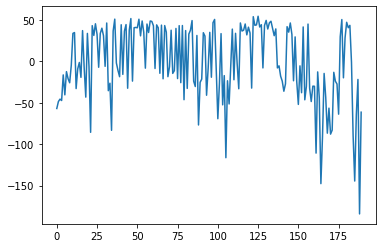

In [10]:
plt.plot(reward_history)

In [46]:
file=open('data.txt')
lines = file.readlines()
num_nodes = int(lines[0])
num_edges = int(lines[1])
#agent = Agent(num_nodes , num_nodes)
reward_history = []
cost = 3000
for e in tqdm(range(1)):
    print(cost)
#     if(cost <= 1843):
#         break
    nodes = []
    state = []
    edge_len = [[0]*num_nodes for i in range(num_nodes)]
    god_map = [[0]*num_nodes for i in range(num_nodes)]
    nodes_dis = []
    nodes_dis2 = [[0]*num_nodes for i in range(num_nodes)]
    on_nodes = []
    info_speed = []
    features = []
    prev_features = []
    Adj = [[0]*num_nodes for i in range(num_nodes)]
    
    for i in range(num_nodes):
        state.append([])
        nodes_dis.append([])
        on_nodes.append([])
        curLine = lines[i+2].strip().split(" ")
        intLine = list(map(int, curLine))
        nodes.append([intLine[0], intLine[1], intLine[2]])
        for j in range(i-1, -1, -1):
            dis = distance(nodes, i, j)
            nodes_dis[i].append((j, dis))
            nodes_dis[j].append((i, dis))
            nodes_dis2[i][j] = dis
            nodes_dis2[j][i] = dis
    for i in range(len(nodes_dis)):
        nodes_dis[i].sort(key=lambda nodes_dis: nodes_dis[1])

    for i in range(num_edges):
        curLine = lines[i+2+num_nodes].strip().split(" ")
        intLine = list(map(int, curLine))
        state[intLine[0]].append(intLine[1])
        state[intLine[1]].append(intLine[0])
        edge_len[intLine[0]][intLine[1]] = intLine[2]
        edge_len[intLine[1]][intLine[0]] = intLine[2]
        Adj[intLine[0]][intLine[1]] = 1
        Adj[intLine[1]][intLine[0]] = 1
    Adj = torch.FloatTensor(Adj)
    k_agents = int(lines[2+num_nodes+num_edges])
    
    for k in range(k_agents):
        features.append([])
        prev_features.append([])
        for i in range(num_nodes):
            features[k].append([])
            prev_features[k].append([])
            for j in range(num_nodes):
                features[k][i].append(0)
                prev_features[k][i].append(0)
        
    now_point = [0] * k_agents
    speed = [0]*k_agents
    target = [0]*k_agents
    location = [0]*k_agents
    x_agent = []
    y_agent = []

    for i in range(k_agents):
        x_agent.append([])
        y_agent.append([])
        info_speed.append([])
        curLine = lines[i+3+num_nodes+num_edges].strip().split(" ")
        intLine = list(map(int, curLine))
        now_point[intLine[0]] = intLine[1]
        #now_point[i] = random.randint(0, num_nodes-1)
        speed[intLine[0]] = intLine[2]

    t_constraint = int(lines[3+num_nodes+num_edges+k_agents])
       
    print(now_point)
#     print(state)
#     print(speed)
#     print(edge_len)
    
    history_route = []
    state_map = []
    for i in range(k_agents):
        history_route.append([])
        history_route[i].append(now_point[i])
        on_nodes[now_point[i]].append(i)
        state_map.append([]) 
    for i in range(k_agents):
        state_map[i] = [[0] * num_nodes for i in range(num_nodes)]
    
    finish_count = 0
    cost = 0
    pre_step = [0]*k_agents
    info_clustering = clustering()
    reward_sum = 0.0
    while finish_count < num_edges:
        communication()
#         for i in range(k_agents):
#             for state_index in range(num_nodes):
#                 for state_index2 in range(num_nodes):
#                     if(state_map[i][state_index][state_index2] >= 1):
#                         features[i][state_index][state_index2] = 1
        cost+=1
        for i in range(k_agents):
            list_x = []
            list_y = []
            if target[i]==0:
                  
                for state_index in range(num_nodes):
                    for state_index2 in range(num_nodes):
                        if(state_map[i][state_index][state_index2] >= 1):
                            features[i][state_index][state_index2] = 1
                reward = 0
                pre_step[i] = now_point[i]
                action = model2.take_action(np.array(features[i][now_point[i]]),state[pre_step[i]],True)
                for index_i in range(len(features[i])):
                    for index_j in range(len(features[i][index_i])):
                        prev_features[i][index_i][index_j] = features[i][index_i][index_j]
                now_point[i] = action
                if(god_map[now_point[i]][pre_step[i]] == 0):
                    reward += 1
#                 else:
#                     reward -= features[i][now_point[i]][pre_step[i]] * 0.001
                reward -= edge_len[pre_step[i]][now_point[i]] * 0.001
                if(finish_count >= num_edges - 1 and god_map[now_point[i]][pre_step[i]]==0):
                    done = True
                    reward += 10
                    if(cost <= 3000):
                        reward += 30
                else:
                    done = False
                reward_sum += reward 
                
#                 if god_map[now_point[i]][pre_step[i]]==0:
#                     finish_count+=1
#                 god_map[now_point[i]][pre_step[i]] += 1
#                 god_map[pre_step[i]][now_point[i]] += 1
                state_map[i][now_point[i]][pre_step[i]] += 1
                state_map[i][pre_step[i]][now_point[i]] += 1
                
                features[i][pre_step[i]][now_point[i]] = 1
                features[i][now_point[i]][pre_step[i]] = 1
#                 agent.store_transition(np.array(prev_features[i][pre_step[i]]) , action , reward , np.array(features[i][pre_step[i]]), done)
#                 agent.update_parameters()
                
                target[i] = edge_len[now_point[i]][pre_step[i]]/speed[i]
            location[i]+=1
            draw_flag = 0
            while location[i]>=target[i]:
#                 state_map[i][now_point[i]][pre_step[i]] += 1
#                 state_map[i][pre_step[i]][now_point[i]] += 1
                history_route[i].append(now_point[i])
                if god_map[now_point[i]][pre_step[i]]==0:
                    finish_count+=1
                god_map[now_point[i]][pre_step[i]] += 1
                god_map[pre_step[i]][now_point[i]] += 1

                if(draw_flag == 0):
                    pre_x = ((location[i]-1)/target[i])*nodes[now_point[i]][1] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][1]
                    pre_y = ((location[i]-1)/target[i])*nodes[now_point[i]][2] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][2]
                    now_x = nodes[now_point[i]][1] 
                    now_y = nodes[now_point[i]][2] 
                    list_x.append([pre_x, now_x])
                    list_y.append([pre_y, now_y])
                else:
                    pre_x = nodes[pre_step[i]][1]
                    pre_y = nodes[pre_step[i]][2] 
                    now_x = nodes[now_point[i]][1] 
                    now_y = nodes[now_point[i]][2] 
                    list_x.append([pre_x, now_x])
                    list_y.append([pre_y, now_y])

                for state_index in range(num_nodes):
                    for state_index2 in range(num_nodes):
                        if(state_map[i][state_index][state_index2] >= 1):
                            features[i][state_index][state_index2] = 1
                reward = 0
                pre_step[i] = now_point[i]
                action = model2.take_action(np.array(features[i][now_point[i]]),state[pre_step[i]],True)
                for index_i in range(len(features[i])):
                    for index_j in range(len(features[i][index_i])):
                        prev_features[i][index_i][index_j] = features[i][index_i][index_j]
                now_point[i] = action
                if(god_map[now_point[i]][pre_step[i]] == 0):
                    reward += 1
#                 else:
#                     reward -= features[i][now_point[i]][pre_step[i]] * 0.001
                reward -= edge_len[pre_step[i]][now_point[i]] * 0.001
                if(finish_count >= num_edges - 1 and god_map[now_point[i]][pre_step[i]]==0):
                    done = True
                    reward += 10
                    if(cost <= 3000):
                        reward += 30
                else:
                    done = False
                reward_sum += reward 
                
#                 if god_map[now_point[i]][pre_step[i]]==0:
#                     finish_count+=1
#                 god_map[now_point[i]][pre_step[i]] += 1
#                 god_map[pre_step[i]][now_point[i]] += 1
                state_map[i][now_point[i]][pre_step[i]] += 1
                state_map[i][pre_step[i]][now_point[i]] += 1
                
                features[i][pre_step[i]][now_point[i]] = 1
                features[i][now_point[i]][pre_step[i]] = 1
#                 agent.store_transition(np.array(prev_features[i][pre_step[i]]) , action , reward , np.array(features[i][pre_step[i]]), done)
#                 agent.update_parameters()
                
                location[i] = location[i]-target[i]
                target[i] = edge_len[now_point[i]][pre_step[i]]/speed[i]
                if i in on_nodes[pre_step[i]]:
                    on_nodes[pre_step[i]].remove(i)
                draw_flag = 1
            if (draw_flag == 1):
                pre_x = nodes[pre_step[i]][1] 
                pre_y = nodes[pre_step[i]][2]
                now_x = ((location[i])/target[i])*nodes[now_point[i]][1] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][1]
                now_y = ((location[i])/target[i])*nodes[now_point[i]][2] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][2]
                list_x.append([pre_x, now_x])
                list_y.append([pre_y, now_y])
                x_agent[i].append(list_x)
                y_agent[i].append(list_y)
            else:
                pre_x = ((location[i]-1)/target[i])*nodes[now_point[i]][1] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][1]
                pre_y = ((location[i]-1)/target[i])*nodes[now_point[i]][2] + ((target[i] - (location[i]-1))/target[i])*nodes[pre_step[i]][2]
                now_x = ((location[i])/target[i])*nodes[now_point[i]][1] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][1]
                now_y = ((location[i])/target[i])*nodes[now_point[i]][2] + ((target[i] - location[i])/target[i])*nodes[pre_step[i]][2]
                x_agent[i].append([pre_x, now_x])
                y_agent[i].append([pre_y, now_y])

            if (location[i]/target[i]) > 0.5:
                if i not in on_nodes[now_point[i]]:
                    on_nodes[now_point[i]].append(i)
            else:
                if i not in on_nodes[pre_step[i]]:
                    on_nodes[pre_step[i]].append(i)
    reward_history.append(reward_sum)
    if e  % 1 == 0:
        print(reward_sum)
    if e > 0 and e % 30 == 0:
        agent.update_target_weight()
        

3000
[7, 3, 5]
17.033



In [47]:
print('cost: ', cost, 'ticks')
#print(history_route)

cost:  1681 ticks


In [36]:
torch.save(agent, f"DQN_10.ptmodel")

In [6]:
model2 = torch.load('DQN_10.ptmodel',map_location='cpu')

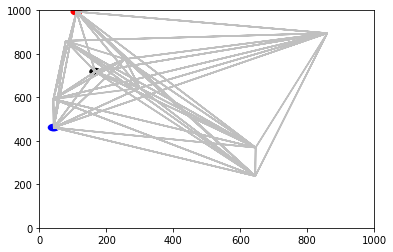

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
x = []
y = []
for i in range(num_nodes):
    node1 = i
    for node2 in state[i]:
        x.append([nodes[node1][1], nodes[node2][1]])
        y.append([nodes[node1][2], nodes[node2][2]])

x_1data = []
y_1data = []
x_2data = []
y_2data = []
x_3data = []
y_3data = []

fig, ax = plt.subplots()
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
line, = ax.plot(0, 0, color = 'silver')
line_1, = ax.plot(0, 0, color='red')
line_2, = ax.plot(0, 0, color='black')
line_3, = ax.plot(0, 0, color='blue')
ball_1 = plt.Circle((5, -5), 18, fc='red')
ball_2 = plt.Circle((5, -5), 18, fc='black')
ball_3 = plt.Circle((5, -5), 18, fc='blue')
def animation_frame(i):
    
    if i >= 0:
        if(i<len(x_agent[0])):
            islist_flag = 0
            for j in range(len(x_agent[0][i])):
                if isinstance(x_agent[0][i][j], list):
                    x_1data.append(x_agent[0][i][j])
                    y_1data.append(y_agent[0][i][j])
                    islist_flag = 1
                    if j == len(x_agent[0][i])-1:
                        ball_1.center = (x_agent[0][i][j][1], y_agent[0][i][j][1])
            if(islist_flag == 0):
                x_1data.append(x_agent[0][i])
                y_1data.append(y_agent[0][i])
                ball_1.center = (x_agent[0][i][1], y_agent[0][i][1])

            line_1.set_xdata(x_1data)
            line_1.set_ydata(y_1data)
            
            

        if(i<len(x_agent[1])):
            islist_flag = 0
            for j in range(len(x_agent[1][i])):
                if isinstance(x_agent[1][i][j], list):
                    x_2data.append(x_agent[1][i][j])
                    y_2data.append(y_agent[1][i][j])
                    islist_flag = 1
                    if j == len(x_agent[0][i])-1:
                        ball_2.center = (x_agent[1][i][j][1], y_agent[1][i][j][1])
            if(islist_flag == 0):
                x_2data.append(x_agent[1][i])
                y_2data.append(y_agent[1][i])
                ball_2.center = (x_agent[1][i][1], y_agent[1][i][1])
                
            line_2.set_xdata(x_2data)
            line_2.set_ydata(y_2data)
            
        if(i<len(x_agent[2])):
            islist_flag = 0
            for j in range(len(x_agent[2][i])):
                if isinstance(x_agent[2][i][j], list):
                    x_3data.append(x_agent[2][i][j])
                    y_3data.append(y_agent[2][i][j])
                    islist_flag = 1
                    if j == len(x_agent[0][i])-1:
                        ball_3.center = (x_agent[2][i][j][1], y_agent[2][i][j][1])
            if(islist_flag == 0):
                x_3data.append(x_agent[2][i])
                y_3data.append(y_agent[2][i])
                ball_3.center = (x_agent[2][i][1], y_agent[2][i][1])

            line_3.set_xdata(x_3data)
            line_3.set_ydata(y_3data)
    
    return line_1,line_2,line_3,ball_1,ball_2,ball_3,
def init():
    line.set_xdata(x)
    line.set_ydata(y)
    
    line_1.set_xdata(x_agent[0][0][0])
    line_1.set_ydata(y_agent[0][0][0])
    
    line_2.set_xdata(x_agent[1][0][0])
    line_2.set_ydata(y_agent[1][0][0])
    
    line_3.set_xdata(x_agent[2][0][0])
    line_3.set_ydata(y_agent[2][0][0])
    
    ball_1.center = (x_agent[0][0][0], y_agent[0][0][0])
    ax.add_patch(ball_1)
    
    ball_2.center = (x_agent[1][0][0], y_agent[1][0][0])
    ax.add_patch(ball_2)
    
    ball_3.center = (x_agent[2][0][0], y_agent[2][0][0])
    ax.add_patch(ball_3)
    
    return line, line_1,line_2,line_3, ball_1,ball_2,ball_3,
    
animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(-2, len(x_agent[0])+10, 1), init_func=init, interval=10)
plt.show()
animation.save('basic_animation3.mp4')

In [11]:
print(len(x_1data),len(x_2data),len(x_3data))

NameError: name 'x_1data' is not defined

In [10]:
print(state)

[[4, 3, 1], [3, 0, 2, 4], [3, 4, 1], [0, 1, 2, 4], [0, 2, 3, 1]]
